# Trial of Control Code on Blood Bank Supplied Data

ARCB has supplied data in excel spreadsheets for sole purpose of trialing a new approach to computing optimal order quantities for donors giving blood.  This analysis starts with imprting the data into numpy arrays.  Since this can't be done directly the data were first imported using Pandas and then converted to Numpy arrays.

In [3]:
import pandas as pd                                          # Python dataframes
from statsmodels.tsa.seasonal import seasonal_decompose      # For analysis of issues data
import matplotlib.pyplot as plt                              # Plotting functions
import numpy as np                                           # Numerical Python
%matplotlib inline                 

In [47]:
# The 8 ABO blood types and their proportions
ABO = {'A+': 0.31, 'A-': 0.07, 'AB+': 0.02, 'AB-': 0.01, 'B+': 0.08, 'B-': 0.02, 'O+': 0.40, 'O-': 0.09}

# Import the data directly from the excel workbooks
issues = pd.read_excel('./data/Book5 (002).xlsx', 'Sheet1', usecols=[0, 2, 3])
bookings = pd.read_excel('./data/Book5 (002).xlsx', 'Sheet1', usecols=[11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                        header=1, skip_footer=9889)
inventory = pd.read_excel('./data/Inventory.xlsx')

## Data Validation
### Issues data
#### Analysis

A visual ispection of the issues data suggests it imported correctly

In [48]:
issues.head()

,Date,ABO,Volume
0,2014-07-01,A NEG,88
1,2014-07-01,A POS,471
2,2014-07-01,AB NEG,8
3,2014-07-01,AB POS,30
4,2014-07-01,B NEG,31


What is the ealiest date in the data?

In [49]:
issues.Date.min()

Timestamp('2014-07-01 00:00:00')

What is the latest date in the data?

In [50]:
issues.Date.max()

Timestamp('2018-01-15 00:00:00')

So, the data covers the time period 1 July 2014 up to 15 January 2018.  That's 1295 days of data!  We can check if the time stamps are contiguous by firstly aggregating across blood types, then offseting the index and testing for anything greater than 1 day.  There are no missing days.

In [51]:
# Create a new data frame which groups total issues by day
total_issues=issues.groupby(['Date']).sum()

# Create a column to store the index date
total_issues['index_col'] = total_issues.index

# Compute the difference between the index date and the next index date value.  Missing dates will show up with a
# timedelta object of greater than 1 day
total_issues['delta'] = total_issues['index_col'] - total_issues['index_col'].shift(1)

# Filter to find any deltas that are greater than one day.
total_issues[total_issues['delta'] != pd.Timedelta('1 days')]

,Volume,index_col,delta
Date,,,
2014-07-01,1709,2014-07-01,NaT


We can visualise the time series by zeroing it and running a seasonal decomposition.  The strongest cyclical component has a frequency of 7 days, but there also appears to be an annual seasonal component centred around Xmas and Easter.  On average, issue quantites seem to be decreasing slightly.

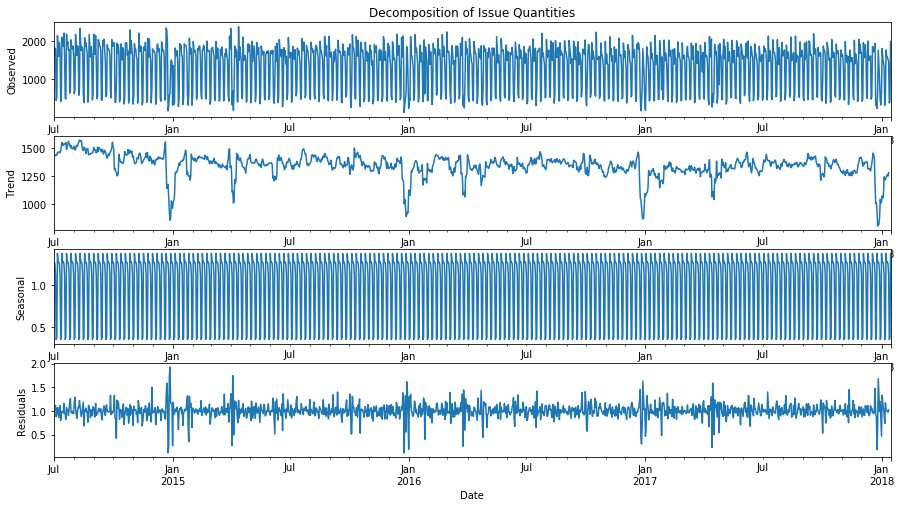

In [54]:
total_issues = issues.groupby(['Date']).sum()
# total_issues['Volume'] -= total_issues['Volume'].mean()

# Decompose issues time series into trend and seasonal components
result = seasonal_decompose(total_issues['Volume'], model='multiplicative', freq=7)

# Create a plot of the decomposed data
plt.figure(1, figsize=[15,8])
plt.subplot(411)
plt.title("Decomposition of Issue Quantities")
result.observed.plot()
plt.ylabel("Observed")
plt.subplot(412)
result.trend.plot()
plt.ylabel("Trend")
plt.subplot(413)
result.seasonal.plot()
plt.ylabel("Seasonal")
plt.subplot(414)
result.resid.plot()
plt.ylabel("Residuals")

#### Comments
The issues data look fit for purpose.  No dates in the range are missing and while there is a downward trend it is pretty small so I won't rescale the data to current levels. I'll probably have to do something about the 7-day cycle but as a first pass I won't bother.  To get it into a numpy array I'll pivot it so that the rows are the day and the columns are the blood type.

### Bookings
#### Analysis
A visual inspection shows the data imported correctly.

In [55]:
bookings

,Date,O POS,O NEG,A POS,A NEG.2,B POS,B NEG,AB POS,AB NEG,Unknown
0,2018-01-16,766,338,597,166,115,31,18,7,191
1,2018-01-17,763,335,571,144,110,41,9,9,160
2,2018-01-18,760,342,548,137,145,30,14,3,176
3,2018-01-19,656,270,478,111,114,35,13,4,132
4,2018-01-20,367,173,318,55,66,16,7,3,114
5,2018-01-21,89,44,67,10,17,7,2,0,42
6,2018-01-22,647,303,525,122,108,26,14,4,96


#### Comments
It looks like appointments are only made one week ahead therefore the delay setting on the Control code will be set to 7.  Appointments on Saturday and Sunday are appreciably lower than other week days.  Unknowns should be distrbuted across the blood types in accordance with the prevalence of that type in the wider population.

### Inventory
#### Analysis
A visual inspection shows the data imported correctly.  There is no data for days 1, 17, 24 and 39. The header structure is different to the other data elements provided.

In [39]:
inventory

,Age,A -,A +,AB -,AB +,B -,B +,O -,O +
0,2,116,451,6,16,23,107,290,582
1,3,112,484,7,14,32,118,237,488
2,4,18,62,0,1,8,22,31,65
3,5,55,255,4,9,10,74,105,299
4,6,101,443,9,10,30,99,200,434
5,7,95,524,6,12,34,106,290,612
6,8,32,372,4,17,19,60,257,501
7,9,37,250,7,9,19,62,154,385
8,10,12,197,5,10,12,40,72,367
9,11,2,30,0,0,0,10,10,20


#### Comments
I'll have to take care moving this data into a numpy array so that missing ages are appropriately handled.  The ages should be transformed to reflect the remaining life of the blood.  Blood of age 43 days will be ignored as it has already outdated.

## Data transformation

In [56]:
# Transform the issues data into a numpy array, replace missing values with 0 and convert to integers
# Note the order of columns is: A-, A+, AB-, AB+, B-, B+, O-, O+
demand = issues.pivot_table(values='Volume', index='Date', columns='ABO').values
demand[np.isnan(demand)] = 0
demand = demand.astype(int)

# bookings need to be sorted in reverse order
bookings = bookings.sort_values(by=['Date'], ascending=False)

# We need the bookings in the same column order
appts = np.zeros((7, 8), dtype=np.int)
appts[:, 0] = bookings['A NEG.2'].values
appts[:, 1] = bookings['A POS'].values
appts[:, 2] = bookings['AB NEG'].values
appts[:, 3] = bookings['AB POS'].values
appts[:, 4] = bookings['B NEG'].values
appts[:, 5] = bookings['B POS'].values
appts[:, 6] = bookings['O NEG'].values
appts[:, 7] = bookings['O POS'].values

# Randomly assign the unknowns to ABO types based on the ABO proportion in the population.  This means there will be a
# slightly different starting point each time the code is executed.
appts += np.array([np.random.multinomial(a, np.array(list(ABO.values())), size=1)[0] 
                   for a in bookings['Unknown'].values])

# Add the missing rows to the inventory data
inventory = inventory.append(pd.DataFrame([[1, 0, 0, 0, 0, 0, 0, 0, 0]], 
                              columns=['Age', 'A -', 'A +', 'AB -', 'AB +', 'B -', 'B +', 'O -', 'O +']))
inventory = inventory.append(pd.DataFrame([[17, 0, 0, 0, 0, 0, 0, 0, 0]], 
                              columns=['Age', 'A -', 'A +', 'AB -', 'AB +', 'B -', 'B +', 'O -', 'O +']))
inventory = inventory.append(pd.DataFrame([[24, 0, 0, 0, 0, 0, 0, 0, 0]], 
                              columns=['Age', 'A -', 'A +', 'AB -', 'AB +', 'B -', 'B +', 'O -', 'O +']))
inventory = inventory.append(pd.DataFrame([[39, 0, 0, 0, 0, 0, 0, 0, 0]], 
                              columns=['Age', 'A -', 'A +', 'AB -', 'AB +', 'B -', 'B +', 'O -', 'O +']))

# Remove expired blood from the inventory
inventory = inventory[inventory['Age'] < 43]

# Redefine age as the number of days remaining
inventory['Age'] = 43 - inventory['Age']

# Sort by age
inventory = inventory.sort_values(by=['Age'])

# Define a new column order...
cols =['Age', 'A -', 'A +', 'AB -', 'AB +', 'B -', 'B +', 'O -', 'O +']

# ...and apply it to the inventory
inventory = inventory[cols]

# Convert to numpy array
inv = inventory.values[:, 1:]

## Set up the Trial

In [1]:
class Control:
    
    def __init__(self, current_inv, demand, epochs, age, delay):
        self.lifespan = current_inv.shape[0]
        self.age = age
        self.ager = np.diag([1] * (self.lifespan - 1), k=-1)
        self.delay = delay
        self.horizon = self.lifespan + delay - age
        self.epochs = epochs
        self.demand = np.random.choice(demand, size=self.horizon * self.epochs)
        self.inv = current_inv
        self.scenarios = np.random.permutation(self.demand).reshape(self.epochs, self.horizon)

    def objective(self, qty, orders=[]):
        shortage = np.array([0.] * self.epochs)
        stock = np.tile(self.inv.copy(), (self.epochs, 1))
        b = np.array([0.] * self.epochs)
        for i in range(self.horizon):
            if orders:
                stock[:, self.age] += orders.pop()
            b += self.scenarios[:, i]
            if i == self.delay:
                stock[:, self.lifespan - self.age - 1] += qty
            for j in range(self.lifespan):
                foo = b.copy()
                b = np.maximum(0, b - stock[:, j])
                stock[:, j] = np.maximum(0, stock[:, j] - foo)
            if i == self.delay:
                shortage = b.copy()
            if i < self.horizon - 1:
                stock = np.dot(stock, self.ager)
        outdate = stock[:, 0].copy()
        return shortage, outdate

    def optimise(self, orders=[]):
        converged = False
        order = 0
        oa = 0
        oc = 0
        shrt, odte = self.objective(oa, orders.copy())
        if shrt.sum() == 0:
            converged = True
            order = int(oa)
        else:
            fa = shrt.mean() - odte.mean()
            oc = max(shrt)
            shrt, odte = self.objective(oc, orders.copy())
            fc = shrt.mean() - odte.mean()
            if odte.sum() == 0:
                converged = True
                order = int(oc)
        while not converged:
            ob = int(round((oa + oc) / 2, 0))
            shrt, odte = self.objective(ob, orders.copy())
            fb = shrt.mean() - odte.mean()
            if oc - oa <= 2:
                foo = [abs(fa), abs(fb), abs(fc)]
                order = [oa, ob, oc][foo.index(min(foo))]
                converged = True
            else:
                if fa > 0 and fb > 0:
                    fa = fb
                    oa = ob
                else:
                    fc = fb
                    oc = ob
        return order

    def visualise(self, lo, hi, save_as=None):
        plotdata = np.array([list(range(lo, hi + 1)), [0] * (hi - lo + 1)], dtype=np.float)
        for qty in plotdata[0]:
            shrt, odte = self.objective(qty)
            plotdata[1][plotdata[0] == qty] = shrt.mean() + odte.mean()
        plt.scatter(plotdata[0], plotdata[1])
        plt.title("Observer function vs Order Quantity")
        plt.ylabel("Value of Observer function")
        plt.xlabel("Order Quantity")
        plt.xticks(np.arange(lo, hi+1, 1.0), rotation=90)
        if save_as is None:
            plt.show()
        else:
            plt.savefig(save_as + '.eps', format='eps', dpi=1000)
            # plt.close()

In [63]:
# These are global environment varibles used throughout the simulation
ABOloc = {'A-': 0, 'A+': 1, 'AB-': 2, 'AB+': 3, 'B-': 4, 'B+': 5, 'O-': 6, 'O+': 7}
epochs = 10000              # The number of demand trajectories to generate for each evaluation of the objective
simlen = 365                # The number of simulated days to calculate
lifespan = 42               # The maximum life of RBCs
delay = appts.shape[0]      # Time between requesting an appointment and the donor giving blood
avg_age = 1                 # The age of a freshly donated unit after processing (indexed at 0)
breakrate = 0.35            # The proportion of donors that break their appointment
escrow = 84                 # The time donors are prevented from giving blood again post donation


# Synthetic demand is drawn from the actual historical demand
actual = demand.copy()
np.random.shuffle(actual)
actual = actual[: simlen, :]

In [72]:
abo = 'AB-'
donor_pop = {'A-': 40000, 'A+': 40000, 'AB-': 415, 'AB+': 1000, 'B-': 40000, 'B+': 40000,
             'O-': 40000, 'O+': 40000}

max_pop = donor_pop[abo]
dmd = demand[:, ABOloc[abo]].copy()          # A copy of historical demand.
stock = np.zeros((simlen + 1, lifespan))     # An empty array to store stock quantities
stock[0] = inv[:, ABOloc[abo]]               # The stock array is initialised with current inventory
shortages = np.zeros((simlen,))              # An empty array to store shortage quantities
outdates = np.zeros((simlen,))               # An empty array to store outdate quantities
orders = np.zeros((simlen,))                 # An empty array to store required donation quantities
supply = np.zeros((simlen, lifespan))        # An empty array to store the actual quantity of blood supplied
available = np.zeros((simlen + 1, ))         # The number of available donors
actual_appt = np.zeros((simlen + 1, delay))  # Donors with an appointment to donate
lockout = np.zeros((simlen + 1, escrow))     # Donors in lockout after donation
actual_appt[0, :] = appts[:, ABOloc[abo]]    # It is assumed that the booking data provided already allow for breaks
received = np.zeros((simlen, ))

order_vec = np.random.binomial(appts[:, ABOloc[abo]], 1 - breakrate).tolist()
bloodbank = Control(stock[0], dmd, epochs, avg_age, delay)

for i in range(simlen):
    bloodbank.inv = stock[i]
                       
    # Determine optimal quantity of blood needed
    required = bloodbank.optimise(order_vec)
    order_vec = [required] + order_vec[: -1]
    orders[i] = required
    
    # The quantity received is a random variable based on the number of appointments and the break rate.
    received[i] = np.random.binomial(actual_appt[i, 0], 1 - breakrate)
    stock[i, lifespan - avg_age - 1] += received[i]
    
    # Remove actual demand from inventory
    b = actual[i, ABOloc[abo]].copy()
    for j in range(lifespan):
        supply[i, j] = np.minimum(b, stock[i, j].copy())
        foo = b
        b = np.maximum(0, b - stock[i, j])
        stock[i, j] = np.maximum(0, stock[i, j] - foo)
        if b == 0:
            break
    
    # Record shortages and outdates
    shortages[i] = b
    outdates[i] = stock[i, 0]
    
    # Age the inventory
    stock[i + 1] += np.dot(stock[i], np.diag([1] * (lifespan - 1), k=-1))
    
    # Update the available number of donors.
    available[i + 1] += available[i] + (actual_appt[i, 0] - received[i]) + lockout[i, 0]
    
    # Update donors in lockout
    lockout[i + 1] = np.dot(lockout[i], np.diag([1] * (escrow - 1), k=-1))
    lockout[i + 1, escrow - 1] = received[i]
    
    # Update appointments
    actual_appt[i + 1] = np.dot(actual_appt[i], np.diag([1] * (delay - 1), k=-1))
    needed = int(required / (1 - breakrate))
    limit = max_pop - (available[i + 1] + actual_appt[i + 1].sum() + lockout[i + 1].sum())
    if needed < available[i + 1]:
        new_appt = needed
        available[i + 1] += -needed
    else:
        new_appt = min(needed, available[i + 1] + limit)
        available[i + 1] = 0
    actual_appt[i + 1, delay - 1] = new_appt
    
    print("Day %s - Demand: %s, Required: %s" % (i, actual[i, ABOloc[abo]], required))

# Save the results    
np.save('./BBtrial/demand' + abo, actual[:, ABOloc[abo]])
np.save('./BBtrial/supply' + abo, supply)
np.save('./BBtrial/inventory' + abo, stock)
np.save('./BBtrial/orders' + abo, orders)
np.save('./BBtrial/bookings' + abo, actual_appt)
np.save('./BBtrial/received' + abo, received)
np.save('./BBtrial/shortages' + abo, shortages)
np.save('./BBtrial/outdates' + abo, outdates)
np.save('./BBtrial/available' + abo, available)
np.save('./BBtrial/lockout' + abo, lockout)

Day 0 - Demand: 5, Required: 0
Day 1 - Demand: 4, Required: 0
Day 2 - Demand: 0, Required: 0
Day 3 - Demand: 10, Required: 0
Day 4 - Demand: 6, Required: 0
Day 5 - Demand: 0, Required: 6
Day 6 - Demand: 14, Required: 0
Day 7 - Demand: 6, Required: 5
Day 8 - Demand: 4, Required: 6
Day 9 - Demand: 0, Required: 4
Day 10 - Demand: 0, Required: 0
Day 11 - Demand: 0, Required: 0
Day 12 - Demand: 0, Required: 0
Day 13 - Demand: 1, Required: 2
Day 14 - Demand: 11, Required: 1
Day 15 - Demand: 6, Required: 9
Day 16 - Demand: 16, Required: 4
Day 17 - Demand: 8, Required: 16
Day 18 - Demand: 0, Required: 8
Day 19 - Demand: 6, Required: 0
Day 20 - Demand: 0, Required: 8
Day 21 - Demand: 0, Required: 0
Day 22 - Demand: 13, Required: 0
Day 23 - Demand: 0, Required: 13
Day 24 - Demand: 1, Required: 1
Day 25 - Demand: 3, Required: 0
Day 26 - Demand: 6, Required: 4
Day 27 - Demand: 4, Required: 6
Day 28 - Demand: 1, Required: 3
Day 29 - Demand: 6, Required: 1
Day 30 - Demand: 2, Required: 6
Day 31 - De

Day 250 - Demand: 4, Required: 5
Day 251 - Demand: 3, Required: 5
Day 252 - Demand: 0, Required: 13
Day 253 - Demand: 0, Required: 0
Day 254 - Demand: 4, Required: 0
Day 255 - Demand: 1, Required: 4
Day 256 - Demand: 3, Required: 4
Day 257 - Demand: 2, Required: 3
Day 258 - Demand: 0, Required: 2
Day 259 - Demand: 1, Required: 0
Day 260 - Demand: 0, Required: 0
Day 261 - Demand: 3, Required: 0
Day 262 - Demand: 0, Required: 1
Day 263 - Demand: 1, Required: 0
Day 264 - Demand: 6, Required: 3
Day 265 - Demand: 3, Required: 6
Day 266 - Demand: 9, Required: 2
Day 267 - Demand: 5, Required: 9
Day 268 - Demand: 4, Required: 5
Day 269 - Demand: 6, Required: 4
Day 270 - Demand: 0, Required: 6
Day 271 - Demand: 1, Required: 0
Day 272 - Demand: 6, Required: 0
Day 273 - Demand: 8, Required: 4
Day 274 - Demand: 0, Required: 7
Day 275 - Demand: 0, Required: 3
Day 276 - Demand: 7, Required: 0
Day 277 - Demand: 10, Required: 8
Day 278 - Demand: 7, Required: 11
Day 279 - Demand: 6, Required: 7
Day 280

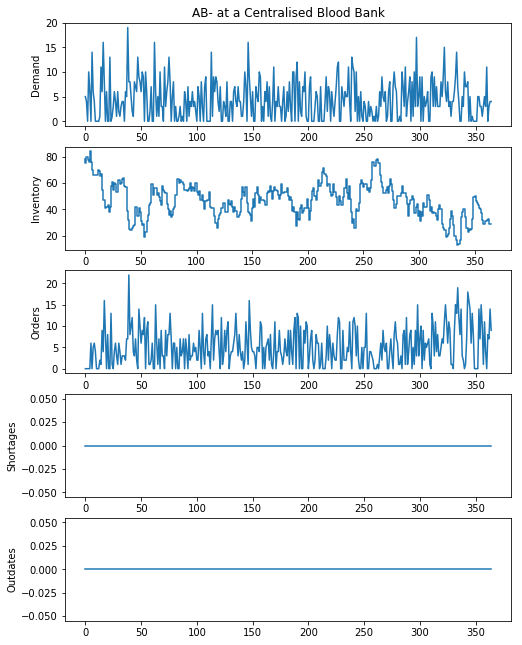

In [73]:
abo = 'AB-'

dmd = np.load('./BBtrial/demand' + abo + '.npy')
stock = np.load('./BBtrial/inventory' + abo + '.npy')
orders = np.load('./BBtrial/orders' + abo + '.npy')
shortages = np.load('./BBtrial/shortages' + abo + '.npy')
ooutdates = np.load('./BBtrial/outdates' + abo + '.npy')

plt.figure(1, figsize=[8,11])
plt.subplot(511)
plt.title(abo + " at a Centralised Blood Bank")
plt.plot(dmd)
plt.ylabel("Demand")
plt.subplot(512)
plt.step(x=range(simlen+1), y=stock.sum(axis=1))
plt.ylabel("Inventory")
plt.subplot(513)
plt.plot(orders)
plt.ylabel("Orders")
plt.subplot(514)
plt.plot(shortages)
plt.ylabel("Shortages")
plt.subplot(515)
plt.plot(outdates)
plt.ylabel("Outdates")

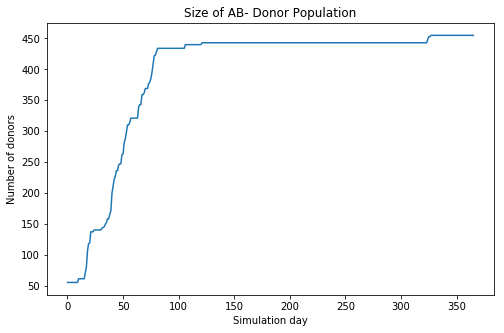

In [70]:
actual_appt = np.load('./BBtrial/bookings' + abo + '.npy')
lockout = np.load('./BBtrial/lockout' + abo + '.npy')
available = np.load('./BBtrial/available' + abo + '.npy')
population = available + actual_appt.sum(axis=1) + lockout.sum(axis=1)
plt.figure(1, figsize=[8,5])
plt.plot(population)
plt.title("Size of " + abo + " Donor Population")
plt.ylabel('Number of donors')
plt.xlabel('Simulation day')
# plt.savefig('dnrpop.eps', format='eps', dpi=1000)

In [67]:
max(population)

455.0